## 1.Aurelia Margin bin50 Reports

In [1]:
import scanpy as sc

In [2]:
# Aurelia Margin Info: 8546 spots * 20613 transcript_ids
st_AureliaMargin = sc.read_h5ad("./Data/AureliaMargin.bin50.normalized.h5ad")
st_AureliaMargin

AnnData object with n_obs × n_vars = 8546 × 20613
    obs: 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'leiden', 'orig.ident', 'x', 'y'
    var: 'real_gene_name', 'n_cells', 'n_counts', 'mean_umi', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'old_name'
    uns: 'bin_size', 'bin_type', 'dendrogram_leiden', 'gene_exp_leiden', 'hvg', 'key_record', 'leiden_colors', 'leiden_resolution', 'log1p', 'merged', 'neighbors', 'omics', 'pca_variance_ratio', 'rank_genes_groups', 'resolution', 'result_keys', 'sn'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

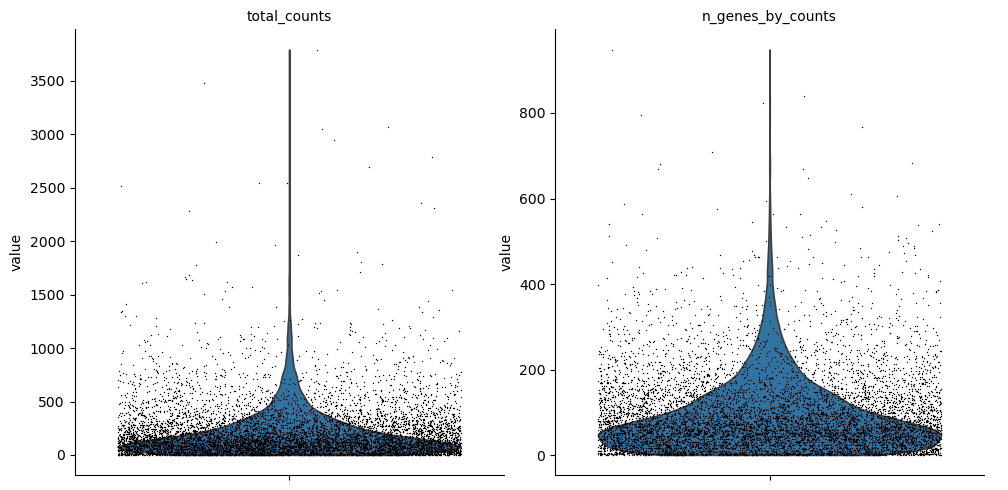

In [3]:
# Violin plots show the distribution of deduplicated MID count and gene types in each bin
sc.pl.violin(st_AureliaMargin, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

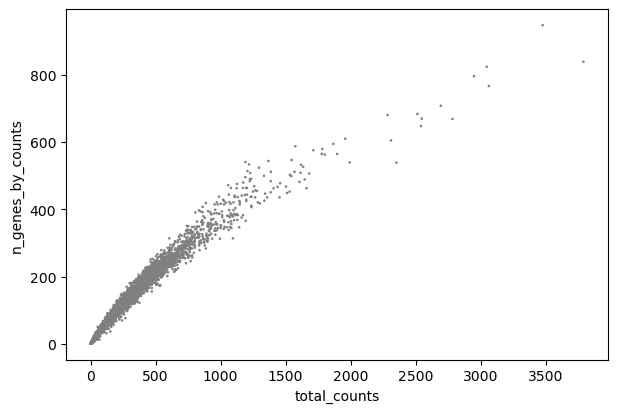

In [4]:
# Scatter QC plots
sc.pl.scatter(st_AureliaMargin, x='total_counts', y='n_genes_by_counts')

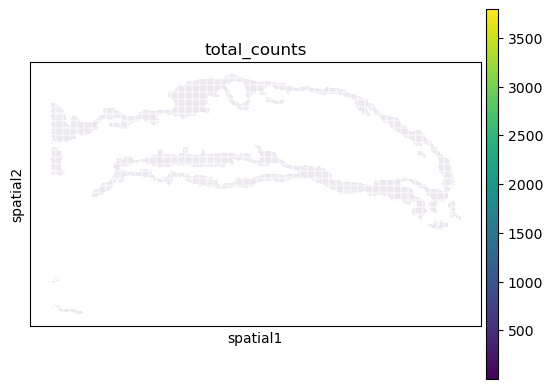

In [5]:
# Spatial Gene Expression Distribution
sc.pl.spatial(st_AureliaMargin, color='total_counts', spot_size=15, cmap='viridis')

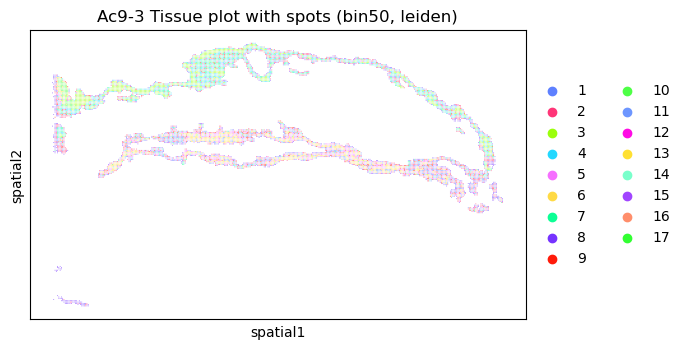

In [6]:
# Clustering spots (bin50) under tissue covered with the Leiden algorithm
sc.pl.spatial(
    st_AureliaMargin,
    color="leiden",
    spot_size=30,
    title="Ac9-3 Tissue plot with spots (bin50, leiden)",
    # ax=ax,
    show=True
)

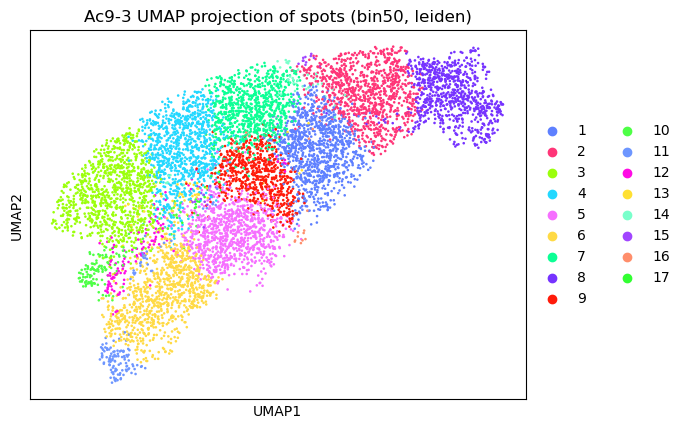

In [7]:
# UMAP projections of spots (bin50) colored by automated clustering.
sc.pl.umap(st_AureliaMargin, color='leiden', title='Ac9-3 UMAP projection of spots (bin50, leiden)')

/tmp/ipykernel_3830003/3407807882.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Cluster", y="Count", palette="viridis")


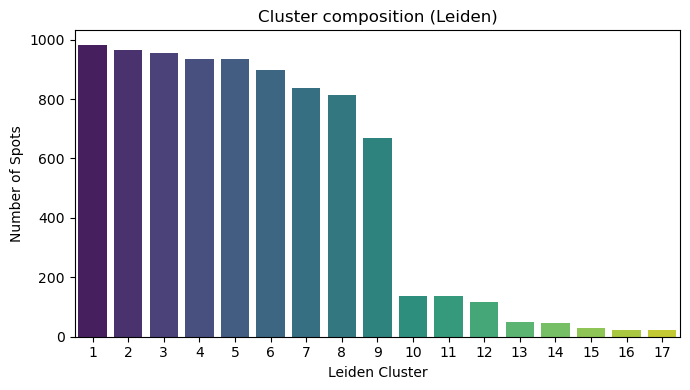

In [43]:
import seaborn as sns
import pandas as pd

counts = st_AureliaMargin.obs['leiden'].value_counts().sort_index()
df = pd.DataFrame({"Cluster": counts.index, "Count": counts.values})

plt.figure(figsize=(7,4))
# sns.barplot(data=df, x="Cluster", y="Count", palette="viridis")
sns.barplot(data=df, x="Cluster", y="Count", palette="viridis")
plt.title("Cluster composition (Leiden)")
plt.xlabel("Leiden Cluster")
plt.ylabel("Number of Spots")
plt.tight_layout()
plt.show()

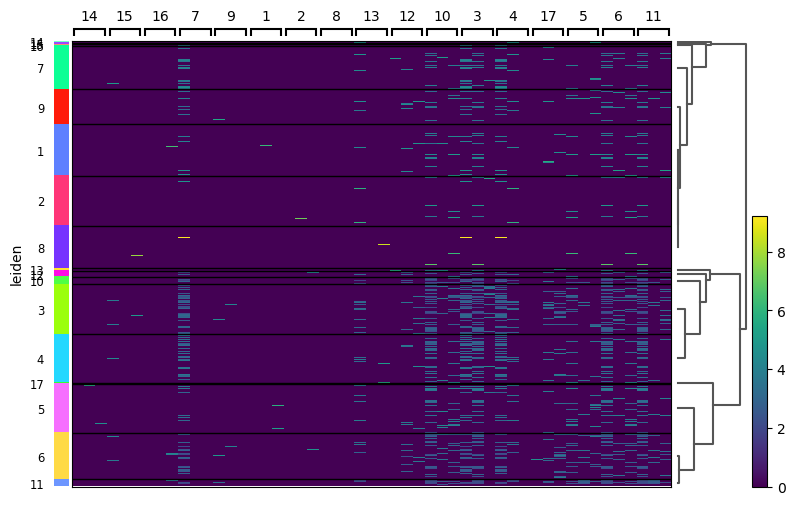

In [8]:
# Marker heatmap / dotplot
sc.pl.rank_genes_groups_heatmap(st_AureliaMargin, n_genes=3, groupby='leiden', use_raw=True)

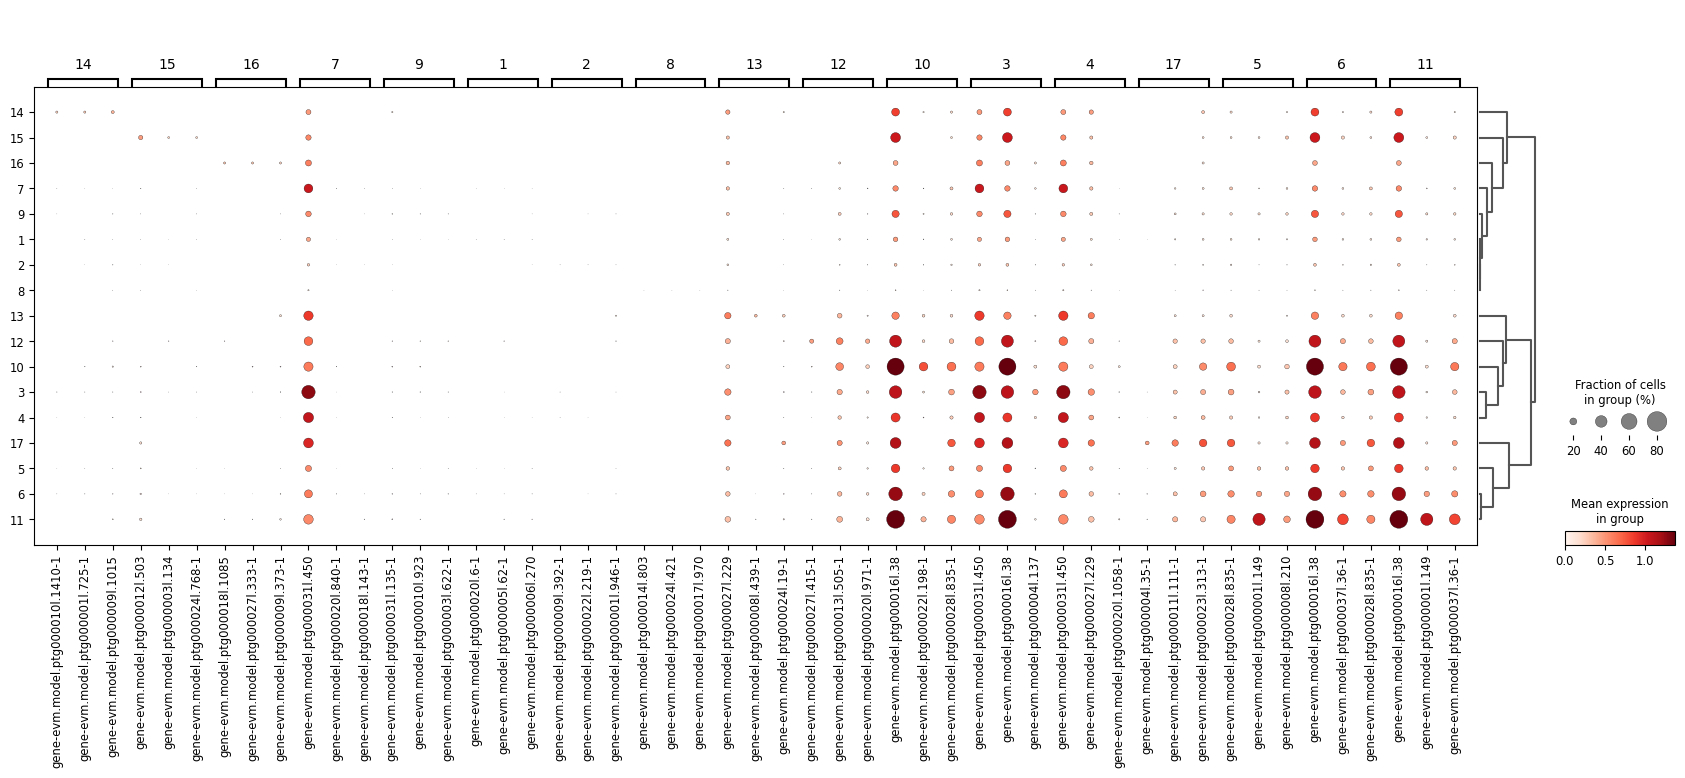

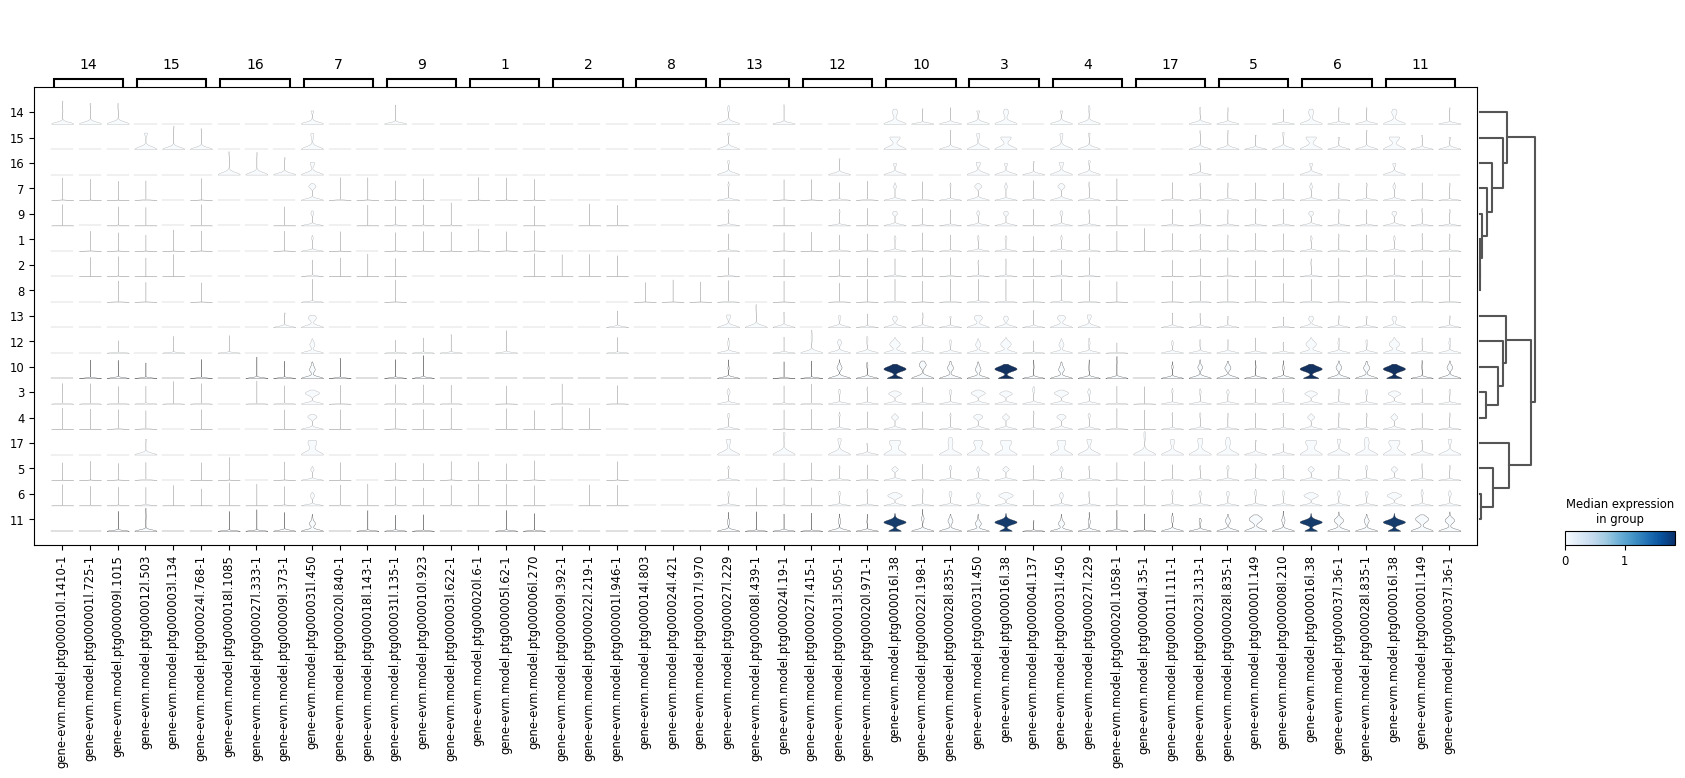

In [9]:
sc.pl.rank_genes_groups_dotplot(st_AureliaMargin, n_genes=3)
sc.pl.rank_genes_groups_stacked_violin(st_AureliaMargin, n_genes=3)

## 2.Hierarchical Clustering

In [10]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import tacco as tc

In [11]:
# adata_F3.uns["dendrogram_leiden"]
# 步骤 1：读取层级聚类 linkage
linkage = st_AureliaMargin.uns["dendrogram_leiden"]["linkage"]
leiden_order = st_AureliaMargin.uns["dendrogram_leiden"]["categories_ordered"]
print(leiden_order)

['14' '15' '16' '7' '9' '1' '2' '8' '13' '12' '10' '3' '4' '17' '5' '6'
 '11']


In [12]:
# 步骤 2：基于层级聚类自动切成 3 个大类
from scipy.cluster.hierarchy import fcluster

# linkage 是层级聚类矩阵
super_cluster_labels = fcluster(linkage, 3, criterion="maxclust")
print(super_cluster_labels)

[1 1 2 2 3 3 1 1 1 2 3 2 2 1 1 1 3]


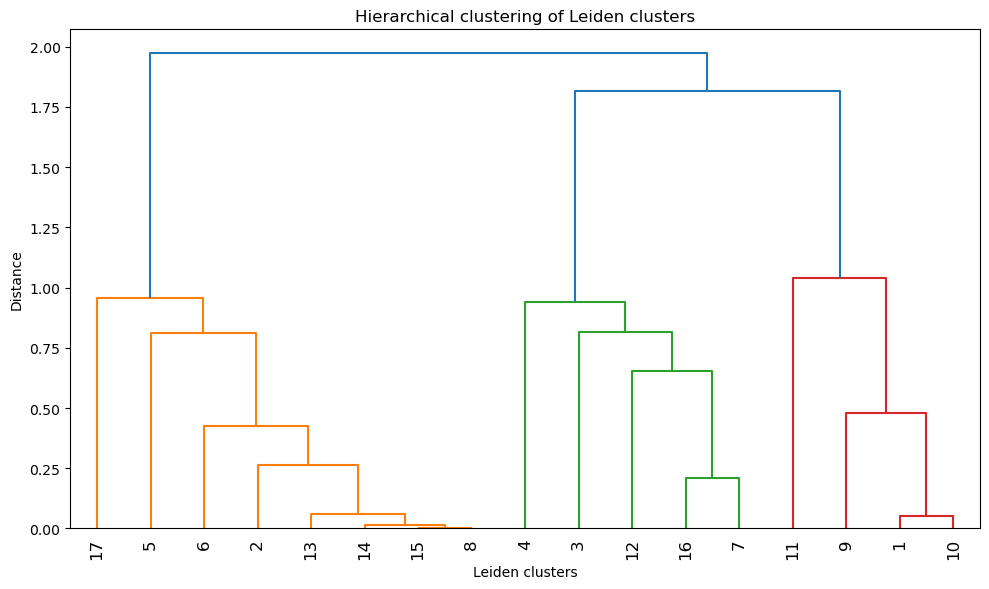

In [13]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

# 提取 dendrogram 信息
linkage = st_AureliaMargin.uns["dendrogram_leiden"]["linkage"]
labels = st_AureliaMargin.uns["dendrogram_leiden"]["categories_ordered"]

# 绘制 dendrogram
plt.figure(figsize=(10, 6))
dendrogram(
    linkage,
    labels=labels,
    orientation='top',       # 横向展示 cluster 层次关系
    leaf_rotation=90,        # 标签旋转 90 度，便于阅读
    color_threshold=None     # 显示完整树，不自动着色
)
plt.title("Hierarchical clustering of Leiden clusters")
plt.xlabel("Leiden clusters")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [14]:
# -------------- Step 3：映射到 Leiden cluster 顺序 --------------
mapping = dict(zip(leiden_order, super_cluster_labels))

# -------------- Step 4：添加文字标签 cluster1/2/3 --------------
label_map = {1: "c1", 2: "c2", 3: "c3"}

st_AureliaMargin.obs["super_leiden"] = (
    st_AureliaMargin.obs["leiden"]
    .map(mapping)           # 映射成 1/2/3
    .map(label_map)         # 再映射成 cluster1/2/3
)

# 查看结果
print(st_AureliaMargin.obs["super_leiden"].value_counts())

super_leiden
c1    3752
c2    2870
c3    1924
Name: count, dtype: int64


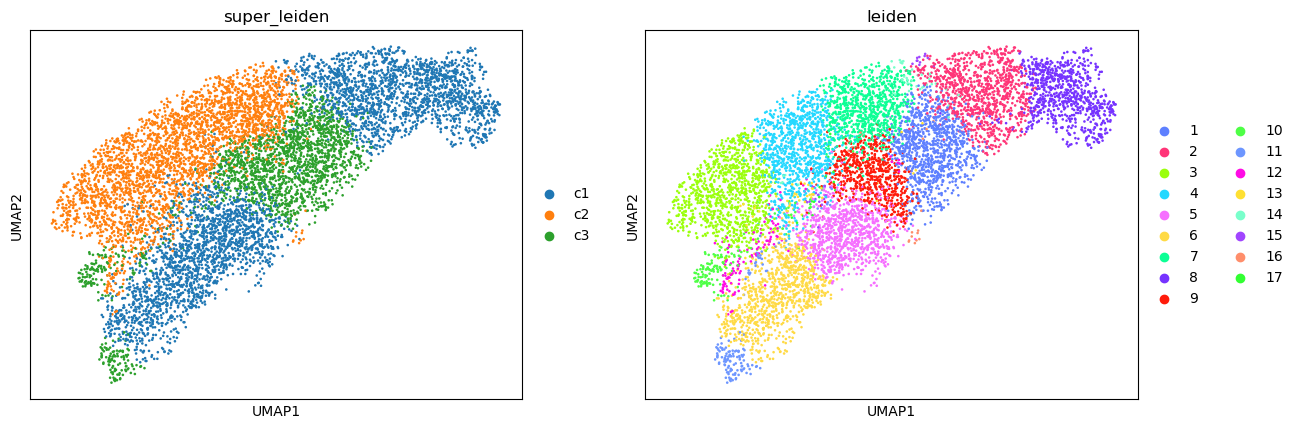

In [15]:
# UMAP
sc.pl.umap(st_AureliaMargin, color=['super_leiden', 'leiden'])

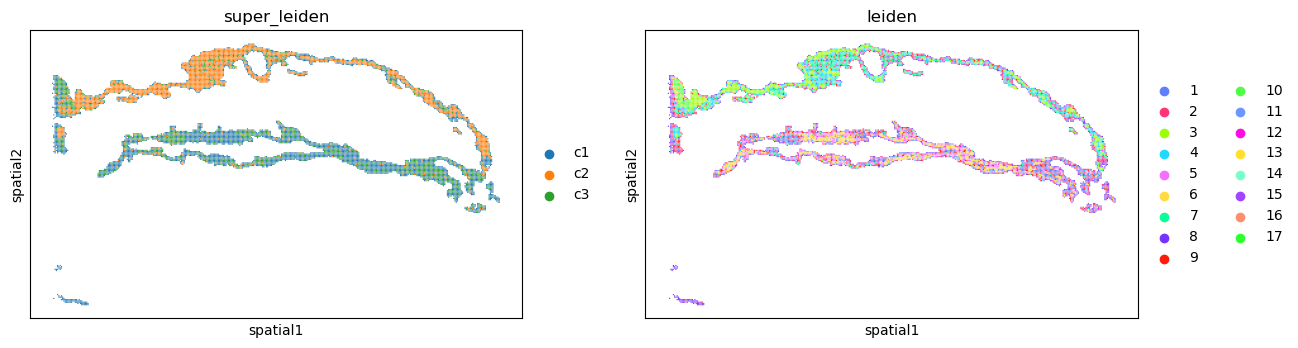

In [16]:
# Spatial
sc.pl.spatial(st_AureliaMargin, color=['super_leiden', 'leiden'], spot_size=50)

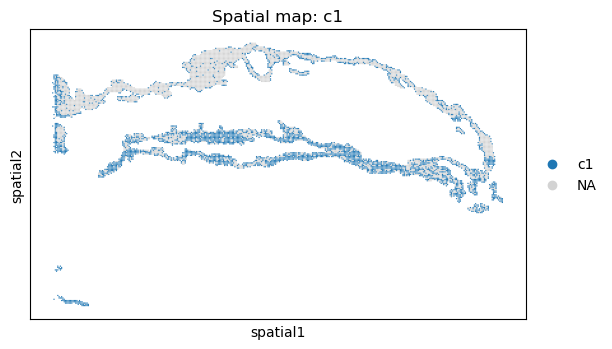

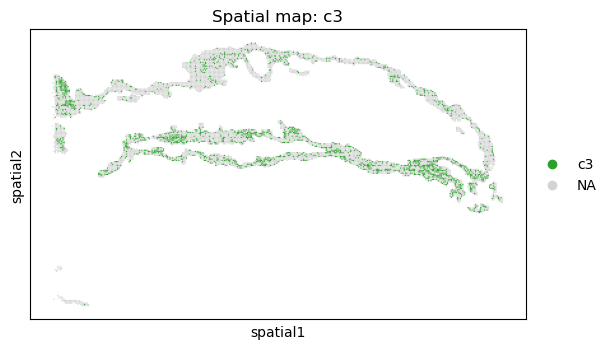

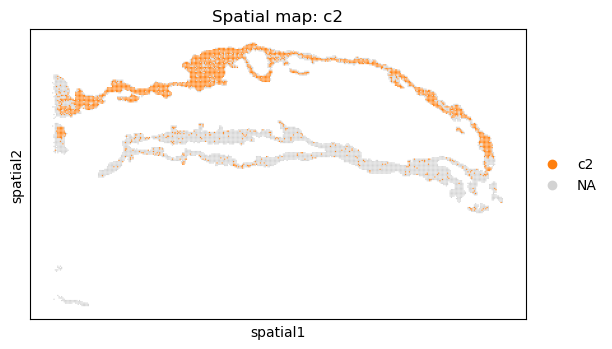

In [17]:
celltypes = st_AureliaMargin.obs["super_leiden"].unique().tolist()

for ct in celltypes:
    sc.pl.spatial(
        st_AureliaMargin,
        color="super_leiden",
        groups=[ct],          # ⭐ 只显示一个 celltype
        spot_size=50,
        title=f"Spatial map: {ct}"
    )


## 3.Orthogroup Processing

### 3.1 transcripts to OGs mapping

In [18]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata

def adata_to_orthogroup(
    adata,
    og_map_path,
    save_path=None
):
    """
    将AnnData对象的基因映射为orthogroup，并合并同OG表达（均值），返回新AnnData对象。
    :param adata_path: 原始h5ad文件路径
    :param og_map_path: 两列(protein_id, orthogroup)的OG映射csv路径
    :param save_path: 若不为None，则保存为此h5ad
    :return: 新的OG级别AnnData对象
    """
    print(f"\n===== 处理 {adata} =====")
    # 1. 读取AnnData
    # adata = sc.read_h5ad(adata_path)
    adata = adata.copy()
    print(f"原始基因数量：{adata.n_vars}")
    # 2. 保存原始gene_id
    adata.var['raw_gene_id'] = adata.var_names
    # 3. 加载OG映射
    og_df = pd.read_csv(og_map_path)
    og_map = og_df.set_index('protein_id')['orthogroup'].to_dict()
    print(f"OG映射表中OG数量：{len(set(og_map.values()))}，蛋白总数：{len(og_map)}")
    # 4. 建orthogroup列
    adata.var['orthogroup'] = adata.var_names.map(lambda x: og_map[x] if x in og_map else x)
    n_mapped = sum(~adata.var['orthogroup'].eq(adata.var['raw_gene_id']))
    n_unmapped = sum(adata.var['orthogroup'].eq(adata.var['raw_gene_id']))
    print(f"能被映射到OG的基因数：{n_mapped}，未能映射的：{n_unmapped}")
    # 5. 表达聚合
    expr_df = pd.DataFrame(
        adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X,
        columns=adata.var_names,
        index=adata.obs_names
    )
    expr_df.columns = adata.var['orthogroup'].values
    og_before = expr_df.shape[1]
    # 聚合时可以考虑sum或mean
    expr_og_df = expr_df.groupby(expr_df.columns, axis=1).sum()
    og_after = expr_og_df.shape[1]
    print(f"整合前OG维度（含重复）：{og_before}，整合后唯一OG数量：{og_after}")
    # 6. 构建新AnnData
    adata_og = anndata.AnnData(
        X=expr_og_df.values,
        obs=adata.obs.copy(),
        var=pd.DataFrame(index=expr_og_df.columns)
    )
    adata_og.uns = adata.uns.copy()
    adata_og.obsm = adata.obsm.copy()
    if save_path is not None:
        adata_og.write_h5ad(save_path)
        print(f"已保存至：{save_path}")
    print(f"新 AnnData: cells = {adata_og.n_obs}，OG = {adata_og.n_vars}\n")
    return adata_og

### 3.2 Aurelia mapped

In [19]:
# 海月水母 Auco
og_map_path = f"/share/home/zhangze/zz/NeuralOrigin/Github/AcoProtocol/Data/2_OrthoFinderSpeciesOrthogroup/Auco.protein_to_orthogroup.csv"

print(st_AureliaMargin)
st_AureliaMargin_og = adata_to_orthogroup(st_AureliaMargin, og_map_path)
print(st_AureliaMargin_og)

AnnData object with n_obs × n_vars = 8546 × 20613
    obs: 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'leiden', 'orig.ident', 'x', 'y', 'super_leiden'
    var: 'real_gene_name', 'n_cells', 'n_counts', 'mean_umi', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'old_name'
    uns: 'bin_size', 'bin_type', 'dendrogram_leiden', 'gene_exp_leiden', 'hvg', 'key_record', 'leiden_colors', 'leiden_resolution', 'log1p', 'merged', 'neighbors', 'omics', 'pca_variance_ratio', 'rank_genes_groups', 'resolution', 'result_keys', 'sn', 'super_leiden_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

===== 处理 AnnData object with n_obs × n_vars = 8546 × 20613
    obs: 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'leiden', 'orig.ident', 'x', 'y', 'super_leiden'
    var: 'real_gene_name', 'n_cells', 'n_counts', 'mean_umi', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'old_name'
    uns: 'bin_size', 

/tmp/ipykernel_3830003/2049205116.py:43: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  expr_og_df = expr_df.groupby(expr_df.columns, axis=1).sum()


整合前OG维度（含重复）：20613，整合后唯一OG数量：14087
新 AnnData: cells = 8546，OG = 14087

AnnData object with n_obs × n_vars = 8546 × 14087
    obs: 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'leiden', 'orig.ident', 'x', 'y', 'super_leiden'
    uns: 'bin_size', 'bin_type', 'dendrogram_leiden', 'gene_exp_leiden', 'hvg', 'key_record', 'leiden_colors', 'leiden_resolution', 'log1p', 'merged', 'neighbors', 'omics', 'pca_variance_ratio', 'rank_genes_groups', 'resolution', 'result_keys', 'sn', 'super_leiden_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'


In [20]:
# 海月水母
print(st_AureliaMargin)
print(st_AureliaMargin_og)

AnnData object with n_obs × n_vars = 8546 × 20613
    obs: 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'leiden', 'orig.ident', 'x', 'y', 'super_leiden'
    var: 'real_gene_name', 'n_cells', 'n_counts', 'mean_umi', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'old_name'
    uns: 'bin_size', 'bin_type', 'dendrogram_leiden', 'gene_exp_leiden', 'hvg', 'key_record', 'leiden_colors', 'leiden_resolution', 'log1p', 'merged', 'neighbors', 'omics', 'pca_variance_ratio', 'rank_genes_groups', 'resolution', 'result_keys', 'sn', 'super_leiden_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 8546 × 14087
    obs: 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'leiden', 'orig.ident', 'x', 'y', 'super_leiden'
    uns: 'bin_size', 'bin_type', 'dendrogram_leiden', 'gene_exp_leiden', 'hvg', 'key_record', 'leiden_colors', 'leiden_resolution', 'log1p', 'merged', 'neighbors', 'om

In [21]:
# # 只保留CellType
# adata_Auco_og.obs = adata_Auco_og.obs[['leiden']].copy()
# adata_Auco_og.obs = adata_Auco_og.obs.rename(columns={'leiden': 'CellType'})
# # 只保留 X_umap（如果有多维的obsm，需手动清理其它项）
# adata_Auco_og.obsm = {
#     'X_umap': adata_Auco_og.obsm['X_umap'].copy(),
#     'spatial': adata_Auco_og.obsm['spatial'].copy()
# }
# adata_Auco_og

In [22]:
# # 清空
# adata_Auco_og.uns = {}
# adata_Auco_og

In [23]:
# 修改细胞名
st_AureliaMargin_og.obs.index.name = "CellName"
st_AureliaMargin_og.obs

total_counts  n_genes_by_counts  pct_counts_mt leiden  \
CellName                                                                
7730941138250              5                  1            0.0      8   
7730941138650              2                  1            0.0      8   
7730941139200              1                  1            0.0      8   
7730941139950              1                  1            0.0      8   
7945689502750             12                  5            0.0      8   
...                      ...                ...            ...    ...   
83322365552550           111                 58            0.0      7   
83537113917200             1                  1            0.0      8   
83537113917250             7                  5            0.0      8   
83537113917300             9                  5            0.0      8   
83537113917350            23                 11            0.0      2   

               orig.ident      x      y super_leiden  
CellName                                              
7730941138250      sample   1800   5450           c1  
7730941138650      sample   1800   5850           c1  
7730941139200      sample   1800   6400           c1  
7730941139950      sample   1800   7150           c1  
7945689502750      sample   1850   5150           c1  
...                   ...    ...    ...          ...  
83322365552550     sample  19400  10150           c2  
83537113917200     sample  19450  10000           c1  
83537113917250     sample  19450  10050           c1  
83537113917300     sample  19450  10100           c1  
83537113917350     sample  19450  10150           c1  

[8546 rows x 8 columns]

In [24]:
# 修改基因索引名
st_AureliaMargin_og.var.index.name = "OrthoGene"
st_AureliaMargin_og.var

Empty DataFrame
Columns: []
Index: [OG0000000, OG0000002, OG0000003, OG0000005, OG0000006, OG0000007, OG0000008, OG0000009, OG0000010, OG0000011, OG0000012, OG0000013, OG0000015, OG0000016, OG0000017, OG0000019, OG0000020, OG0000023, OG0000024, OG0000025, OG0000026, OG0000027, OG0000028, OG0000029, OG0000030, OG0000031, OG0000032, OG0000033, OG0000034, OG0000035, OG0000036, OG0000037, OG0000038, OG0000039, OG0000040, OG0000041, OG0000042, OG0000043, OG0000044, OG0000045, OG0000046, OG0000047, OG0000049, OG0000050, OG0000052, OG0000053, OG0000054, OG0000055, OG0000056, OG0000057, OG0000058, OG0000059, OG0000060, OG0000061, OG0000062, OG0000064, OG0000065, OG0000066, OG0000067, OG0000069, OG0000070, OG0000071, OG0000072, OG0000073, OG0000074, OG0000075, OG0000076, OG0000077, OG0000078, OG0000080, OG0000081, OG0000082, OG0000085, OG0000086, OG0000087, OG0000088, OG0000091, OG0000093, OG0000094, OG0000095, OG0000096, OG0000098, OG0000099, OG0000100, OG0000101, OG0000102, OG0000104, OG0000105, OG0000106, OG0000107, OG0000108, OG0000109, OG0000110, OG0000111, OG0000112, OG0000113, OG0000114, OG0000115, OG0000116, OG0000117, ...]

[14087 rows x 0 columns]

In [25]:
# 保存adata数据
raw_Auco_path = "./Data/AureliaMargin.bin50.OGs.normalized.h5ad"
st_AureliaMargin_og.write(raw_Auco_path)

In [26]:
# 导出基因id
st_AureliaMargin_og.var_names.to_series().to_csv('./Data/AureliaMargin.bin50.OGs.txt', index=False, header=False)

### 3.3 Clytia Medusa mapped

In [27]:
# 半球美螅水母 Clhe
adata_path = f"./Data/ClytiaMedusa.sc.normalized.h5ad"
og_map_path = f"./Data/Clytia.protein_to_orthogroup.csv"

sc_Clytia = sc.read_h5ad(adata_path)
print(sc_Clytia)
sc_Clytia_og = adata_to_orthogroup(sc_Clytia, og_map_path)
print(sc_Clytia_og)

AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'UMI Count'
    uns: 'annosSub_colors', 'annos_colors'
    obsm: 'X_umap'

===== 处理 AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'UMI Count'
    uns: 'annosSub_colors', 'annos_colors'
    obsm: 'X_umap' =====
原始基因数量：46716
OG映射表中OG数量：8524，蛋白总数：26832
能被映射到OG的基因数：15613，未能映射的：31103


/tmp/ipykernel_3830003/2049205116.py:43: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  expr_og_df = expr_df.groupby(expr_df.columns, axis=1).sum()


整合前OG维度（含重复）：46716，整合后唯一OG数量：38770
新 AnnData: cells = 13673，OG = 38770

AnnData object with n_obs × n_vars = 13673 × 38770
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'UMI Count'
    uns: 'annosSub_colors', 'annos_colors'
    obsm: 'X_umap'


In [28]:
# 半球美螅水母
print(sc_Clytia)
print(sc_Clytia_og)

AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'UMI Count'
    uns: 'annosSub_colors', 'annos_colors'
    obsm: 'X_umap'
AnnData object with n_obs × n_vars = 13673 × 38770
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'UMI Count'
    uns: 'annosSub_colors', 'annos_colors'
    obsm: 'X_umap'


In [29]:
# # 只保留CellType
# adata_Clhe_og.obs = adata_Clhe_og.obs[['annos']].copy()
# adata_Clhe_og.obs = adata_Clhe_og.obs.rename(columns={'annos': 'CellType'})
# # 只保留 X_umap（如果有多维的obsm，需手动清理其它项）
# adata_Clhe_og.obsm = {'X_umap': adata_Clhe_og.obsm['X_umap'].copy()}
# adata_Clhe_og

In [30]:
# # 清空
# adata_Clhe_og.uns = {}
# adata_Clhe_og

In [31]:
# 修改细胞名
sc_Clytia_og.obs.index.name = "CellName"
sc_Clytia_og.obs

batch  cellRanger_louvain    fed  orgID  \
CellName                                                      
AAACCTGAGAGGGCTT-1      0                  10   True      3   
AAACCTGAGAGGTTAT-1      0                   4  False      9   
AAACCTGAGCGAGAAA-1      0                   3   True      3   
AAACCTGAGCGTGTCC-1      0                  15  False     10   
AAACCTGAGGATTCGG-1      0                   3  False      8   
...                   ...                 ...    ...    ...   
TTTGTCAGTGGACGAT-2      1                  24   True      4   
TTTGTCATCATCTGTT-2      1                   2  False      7   
TTTGTCATCGCCTGAG-2      1                   6  False      7   
TTTGTCATCTAACGGT-2      1                  22   True      3   
TTTGTCATCTGAGTGT-2      1                   0  False      9   

                                  annos                     annosSub  \
CellName                                                               
AAACCTGAGAGGGCTT-1           Nematocyte  Differentiating Nematocytes   
AAACCTGAGAGGTTAT-1     Epidermal/Muscle          Manubrium Epidermis   
AAACCTGAGCGAGAAA-1           Gastroderm            GastroDigestive-A   
AAACCTGAGCGTGTCC-1           Gastroderm            GastroDigestive-D   
AAACCTGAGGATTCGG-1           Gastroderm            GastroDigestive-A   
...                                 ...                          ...   
TTTGTCAGTGGACGAT-2           Gastroderm            GastroDigestive-F   
TTTGTCATCATCTGTT-2  Stem Cell/Germ Cell               Medium Oocytes   
TTTGTCATCGCCTGAG-2               Neural    Neural Cells Early Stages   
TTTGTCATCTAACGGT-2           Gland Cell                Gland Cells-A   
TTTGTCATCTGAGTGT-2  Stem Cell/Germ Cell                      i-Cells   

                    UMI Count  
CellName                       
AAACCTGAGAGGGCTT-1     2099.0  
AAACCTGAGAGGTTAT-1     1643.0  
AAACCTGAGCGAGAAA-1      304.0  
AAACCTGAGCGTGTCC-1     4411.0  
AAACCTGAGGATTCGG-1     4616.0  
...                       ...  
TTTGTCAGTGGACGAT-2     2663.0  
TTTGTCATCATCTGTT-2      600.0  
TTTGTCATCGCCTGAG-2      396.0  
TTTGTCATCTAACGGT-2    28657.0  
TTTGTCATCTGAGTGT-2      653.0  

[13673 rows x 7 columns]

In [32]:
# 修改基因索引名
sc_Clytia_og.var.index.name = "OrthoGene"
sc_Clytia_og.var

Empty DataFrame
Columns: []
Index: [OG0000000, OG0000002, OG0000003, OG0000004, OG0000005, OG0000006, OG0000007, OG0000008, OG0000009, OG0000010, OG0000011, OG0000012, OG0000013, OG0000015, OG0000016, OG0000017, OG0000018, OG0000020, OG0000024, OG0000025, OG0000026, OG0000027, OG0000028, OG0000029, OG0000030, OG0000031, OG0000032, OG0000033, OG0000035, OG0000036, OG0000037, OG0000038, OG0000040, OG0000041, OG0000042, OG0000043, OG0000044, OG0000045, OG0000046, OG0000047, OG0000048, OG0000049, OG0000050, OG0000052, OG0000053, OG0000054, OG0000055, OG0000056, OG0000057, OG0000058, OG0000059, OG0000060, OG0000061, OG0000062, OG0000064, OG0000065, OG0000067, OG0000068, OG0000069, OG0000070, OG0000071, OG0000072, OG0000073, OG0000074, OG0000075, OG0000076, OG0000077, OG0000078, OG0000080, OG0000081, OG0000082, OG0000084, OG0000086, OG0000087, OG0000088, OG0000089, OG0000091, OG0000093, OG0000094, OG0000095, OG0000096, OG0000098, OG0000099, OG0000100, OG0000101, OG0000102, OG0000103, OG0000104, OG0000105, OG0000106, OG0000107, OG0000108, OG0000109, OG0000110, OG0000111, OG0000112, OG0000113, OG0000114, OG0000115, OG0000116, ...]

[38770 rows x 0 columns]

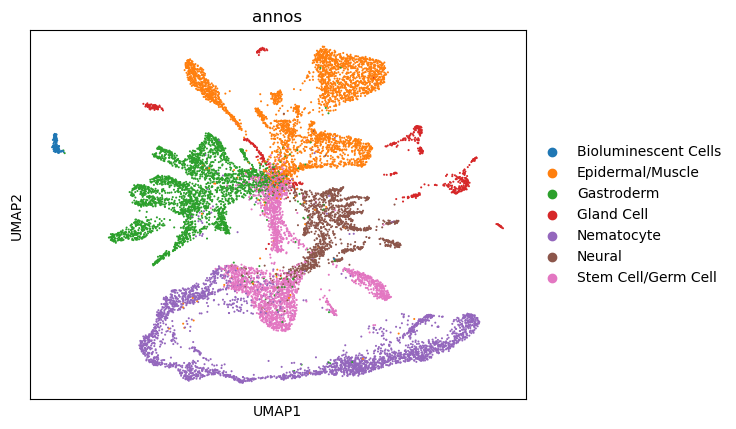

In [33]:
sc.pl.umap(sc_Clytia_og, color=['annos'])

In [34]:
sc_Clytia_og.obs['annos'].value_counts()

annos
Epidermal/Muscle        3254
Gastroderm              2921
Nematocyte              2819
Stem Cell/Germ Cell     2540
Neural                  1387
Gland Cell               634
Bioluminescent Cells     118
Name: count, dtype: int64

In [35]:
# 保存adata数据
raw_Clhe_path = "./Data/ClytiaMedusa.sc.OGs.normalized.h5ad"
sc_Clytia_og.write(raw_Clhe_path)

In [36]:
# 导出基因id
sc_Clytia_og.var_names.to_series().to_csv('./Data/ClytiaMedusa.sc.OGs.txt', index=False, header=False)

## 4.OGs Markers of sc_Clytia and st_AureliaMargin

In [37]:
markers_dict = {
    "Epidermal/Muscle":   ['OG0000432', 'OG0002736', 'OG0001527', 'OG0000253'],
    "Nematocyte":   ['OG0011646', 'OG0001361'],
    "Neural":   ['OG0000166', 'OG0000393']
}

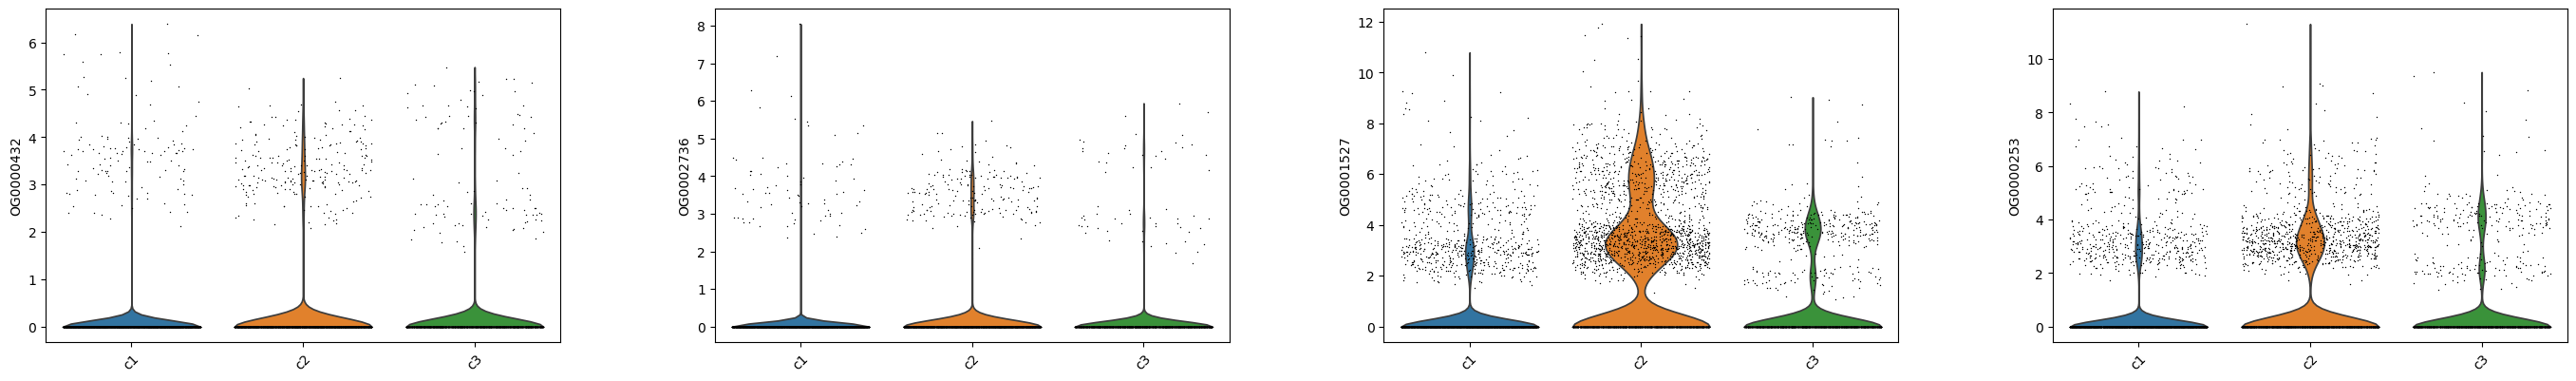

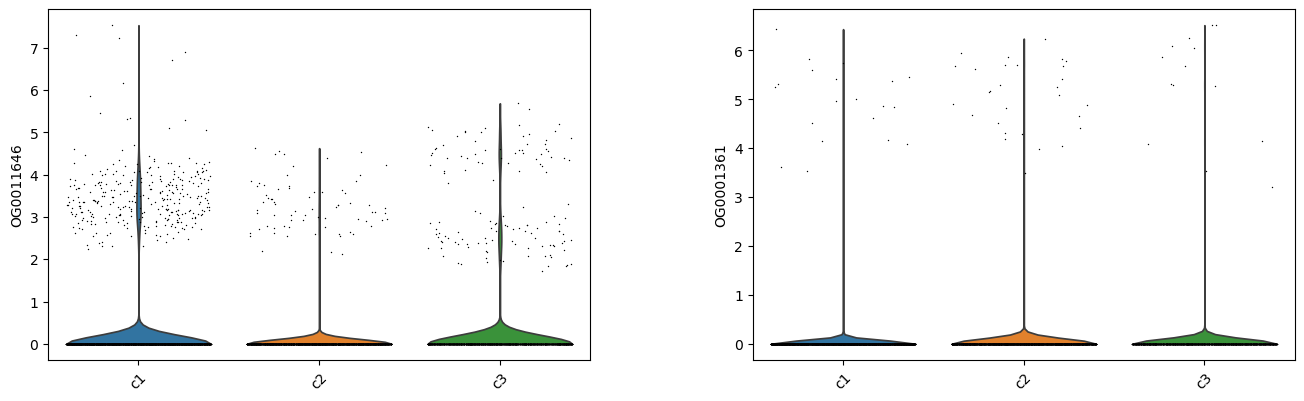

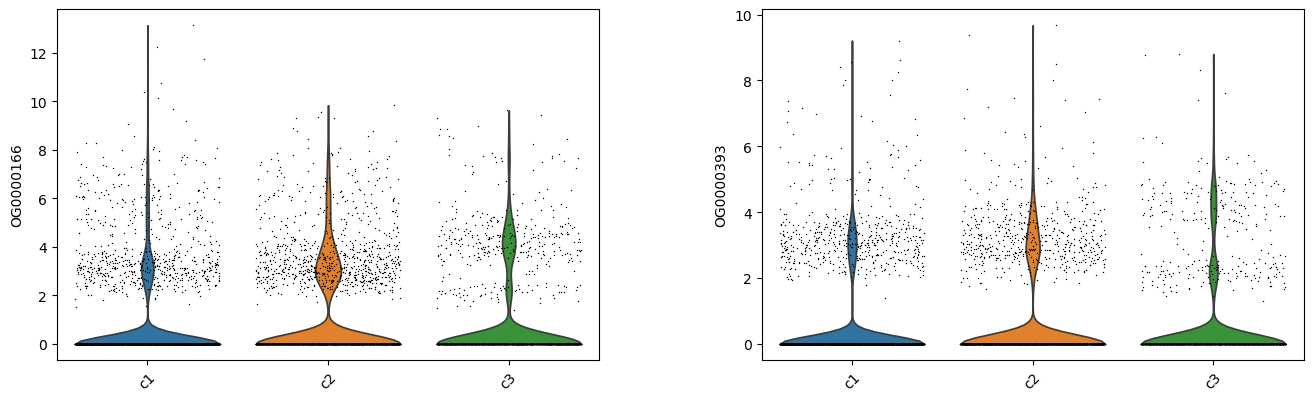

In [45]:
sc.pl.violin(st_AureliaMargin_og, keys=markers_dict['Epidermal/Muscle'], groupby="super_leiden", jitter=0.4, rotation=45, stripplot=True)
sc.pl.violin(st_AureliaMargin_og, keys=markers_dict['Nematocyte'], groupby="super_leiden", jitter=0.4, rotation=45, stripplot=True)
sc.pl.violin(st_AureliaMargin_og, keys=markers_dict['Neural'], groupby="super_leiden", jitter=0.4, rotation=45, stripplot=True)

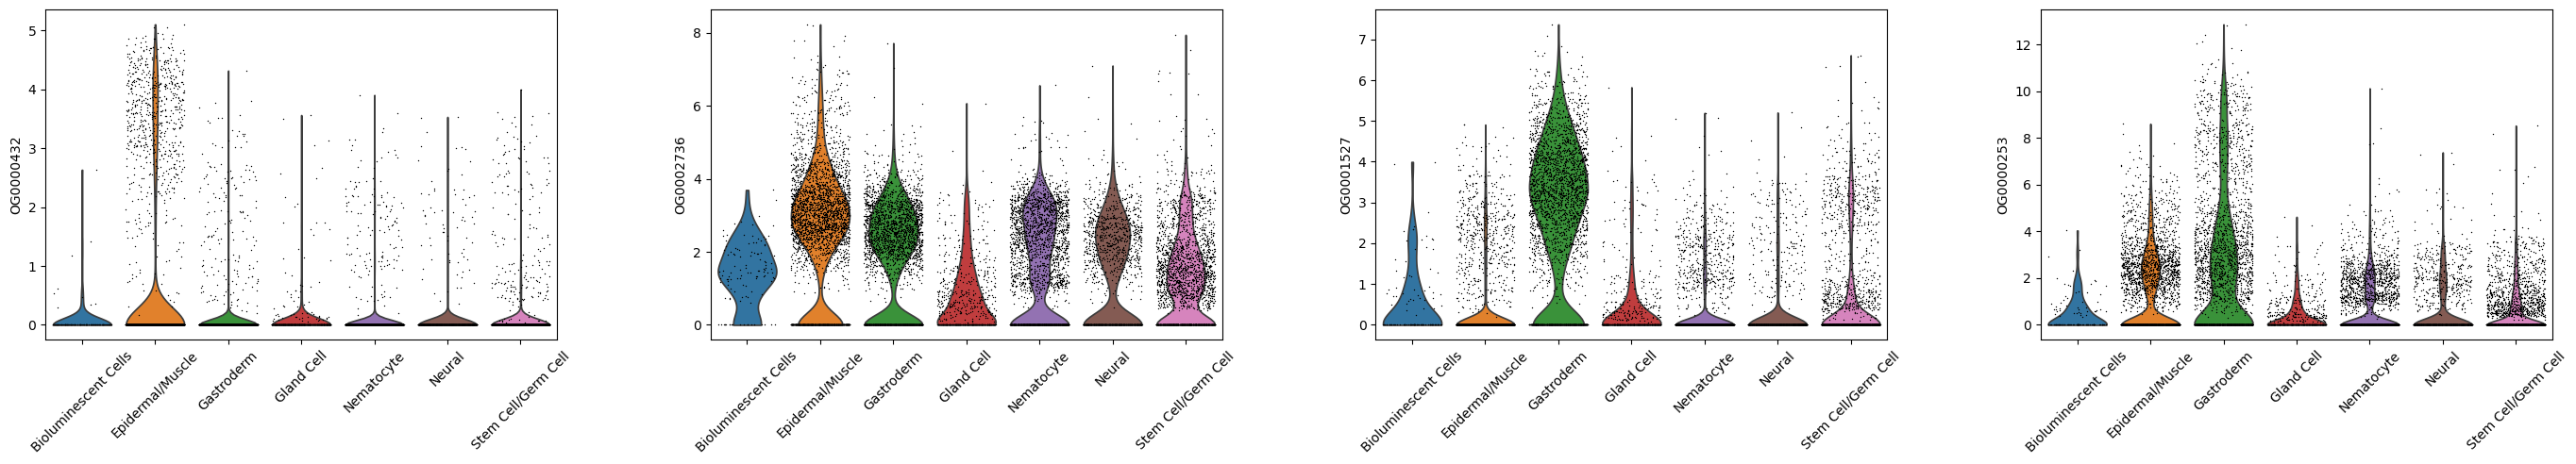

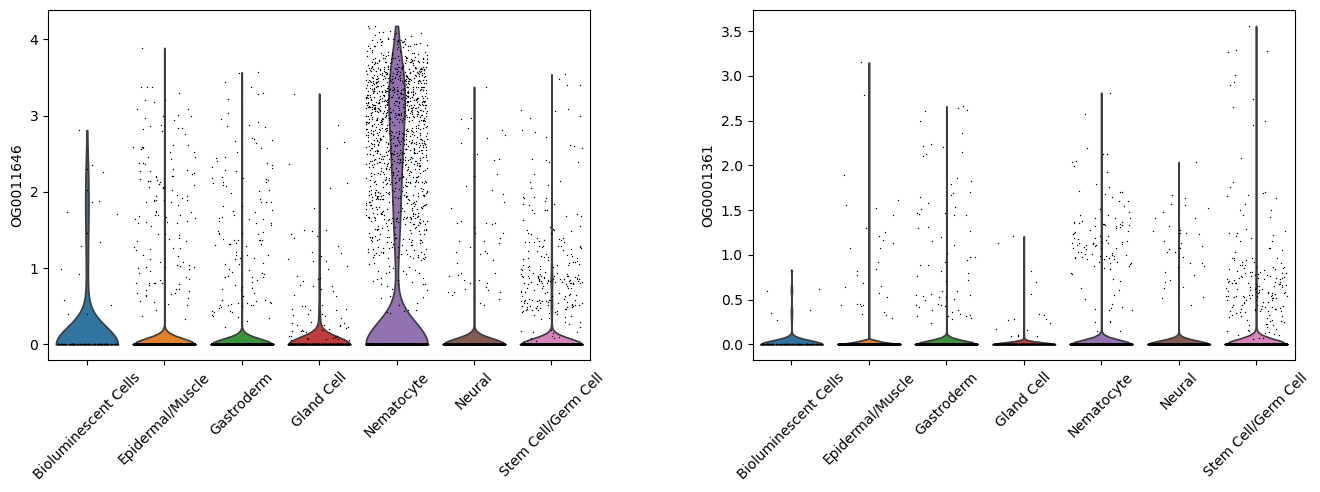

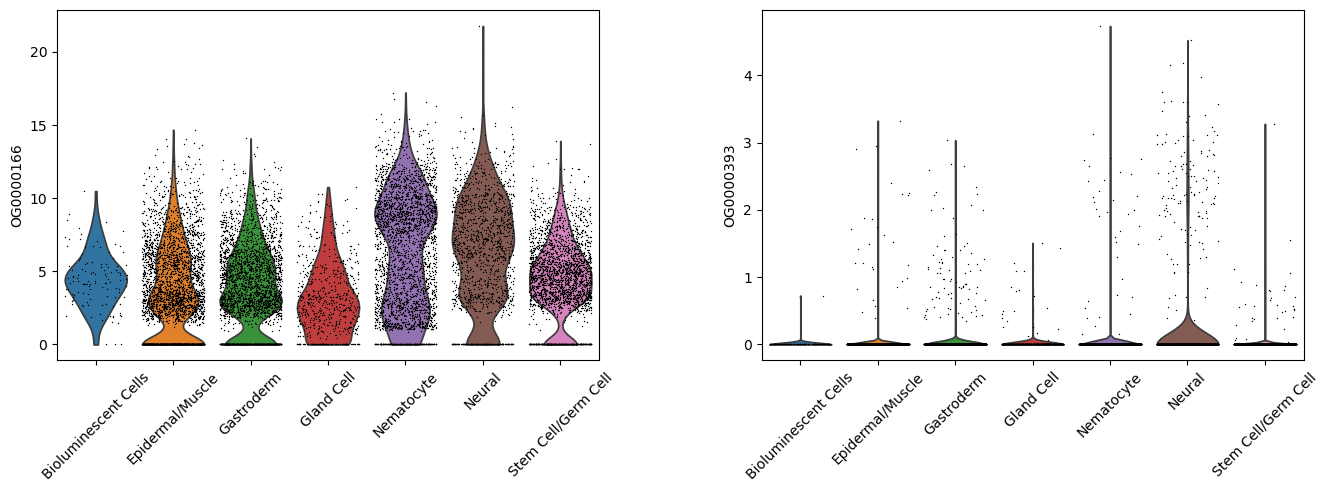

In [46]:
sc.pl.violin(sc_Clytia_og, keys=markers_dict['Epidermal/Muscle'], groupby="annos", jitter=0.4, rotation=45, stripplot=True)
sc.pl.violin(sc_Clytia_og, keys=markers_dict['Nematocyte'], groupby="annos", jitter=0.4, rotation=45, stripplot=True)
sc.pl.violin(sc_Clytia_og, keys=markers_dict['Neural'], groupby="annos", jitter=0.4, rotation=45, stripplot=True)

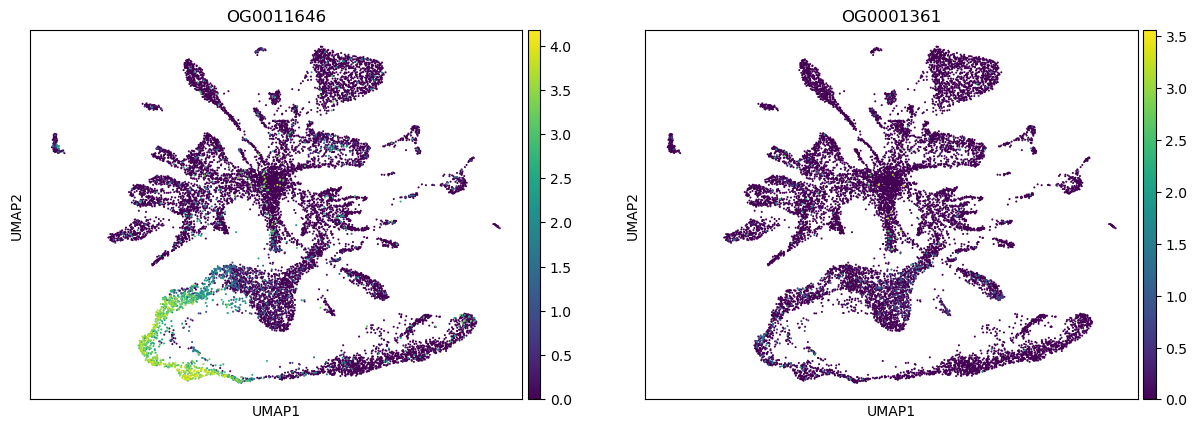

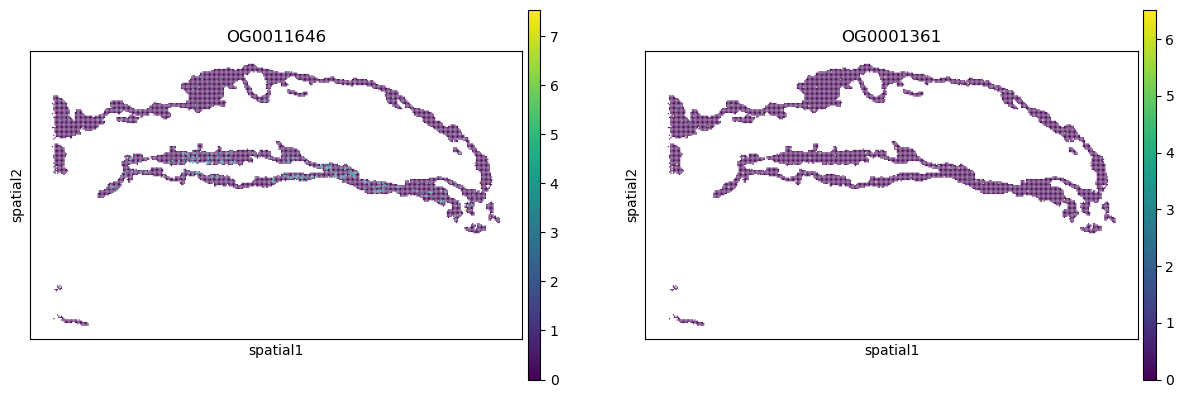

In [49]:
sc.pl.umap(sc_Clytia_og, color=markers_dict['Nematocyte'])
# sc.pl.umap(adata_Auco, color=gene_dict['Nematocyte'])
sc.pl.spatial(st_AureliaMargin_og, color=markers_dict['Nematocyte'], spot_size=50)

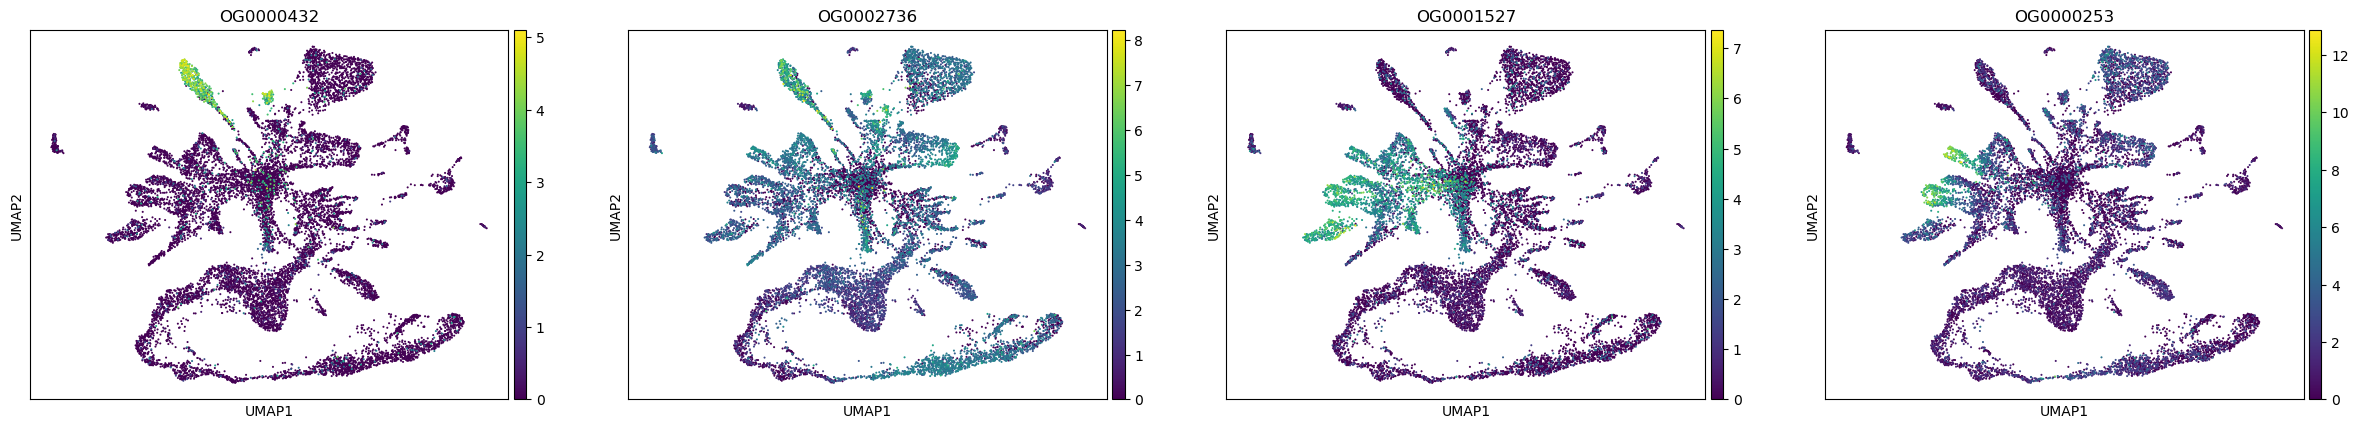

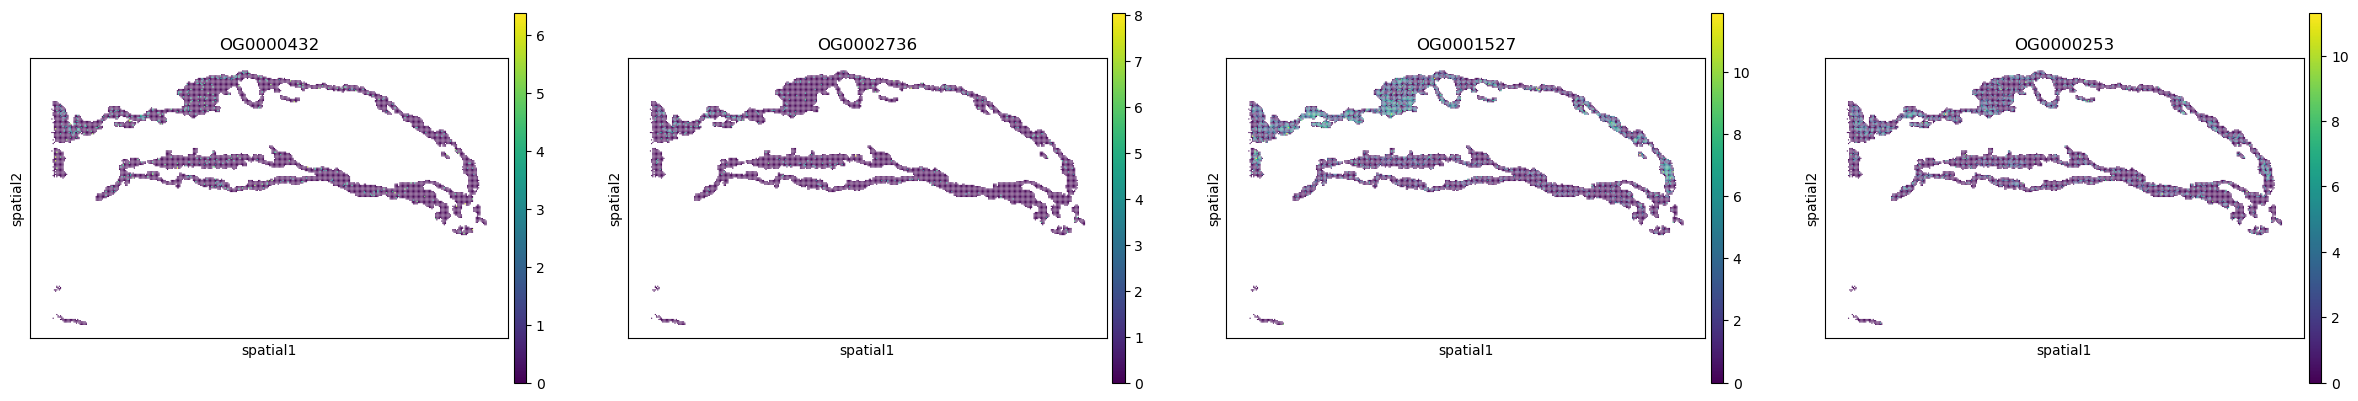

In [50]:
sc.pl.umap(sc_Clytia_og, color=markers_dict['Epidermal/Muscle'])
# sc.pl.umap(adata_Auco, color=gene_dict['Epidermal/Muscle'])
sc.pl.spatial(st_AureliaMargin_og, color=markers_dict['Epidermal/Muscle'], spot_size=50)

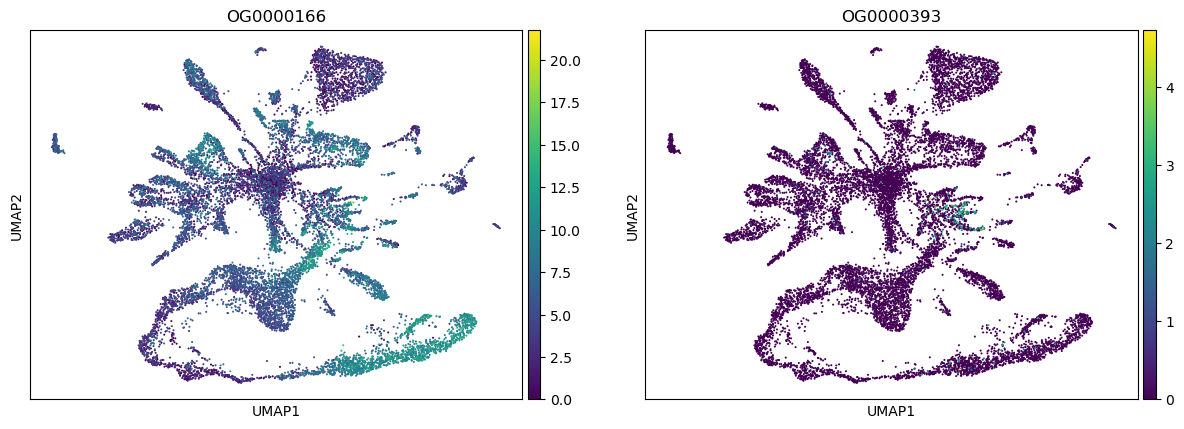

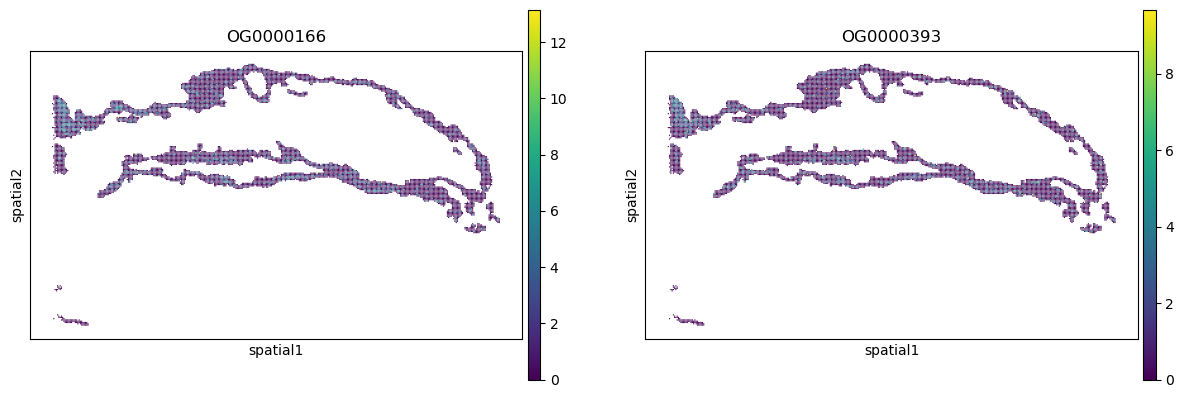

In [51]:
sc.pl.umap(sc_Clytia_og, color=markers_dict['Neural'])
# sc.pl.umap(adata_Auco, color=gene_dict['Neural'])
sc.pl.spatial(st_AureliaMargin_og, color=markers_dict['Neural'], spot_size=50)

## 5.Spatial Annotation

In [72]:
# 定义映射关系
anno_map = {
    "c1": "Nematocyte-related",
    "c2": "Epidermal/Muscle-related",
    "c3": "Neural-related"
}

# 创建新的注释列
st_AureliaMargin_og.obs["cluster_annos"] = st_AureliaMargin_og.obs["super_leiden"].map(anno_map)
# st_AureliaMargin.obs["cluster_annos"] = st_AureliaMargin.obs["super_leiden"].map(anno_map)

# 查看结果
print(st_AureliaMargin_og.obs["cluster_annos"].value_counts())
# print(st_AureliaMargin.obs["cluster_annos"].value_counts())

cluster_annos
Nematocyte-related          3752
Epidermal/Muscle-related    2870
Neural-related              1924
Name: count, dtype: int64


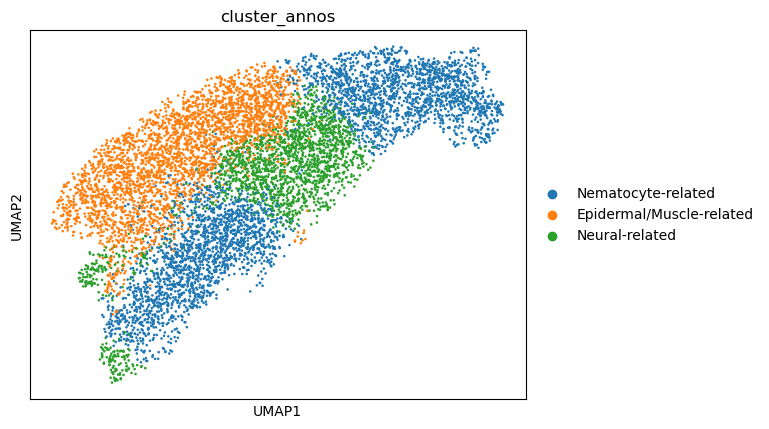

In [75]:
# UMAP
sc.pl.umap(st_AureliaMargin_og, color=['cluster_annos'])

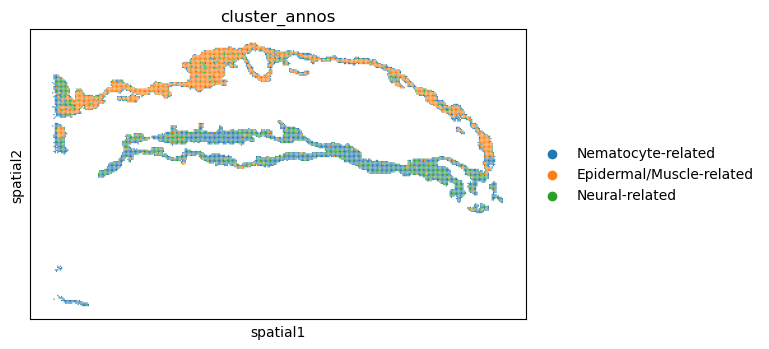

In [76]:
# Spatial
sc.pl.spatial(st_AureliaMargin_og, color=['cluster_annos'], spot_size=50)

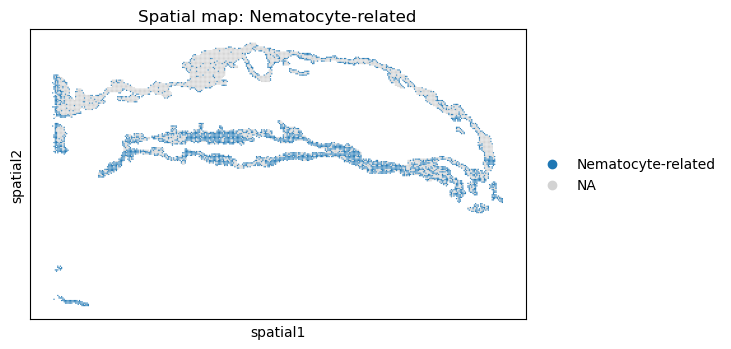

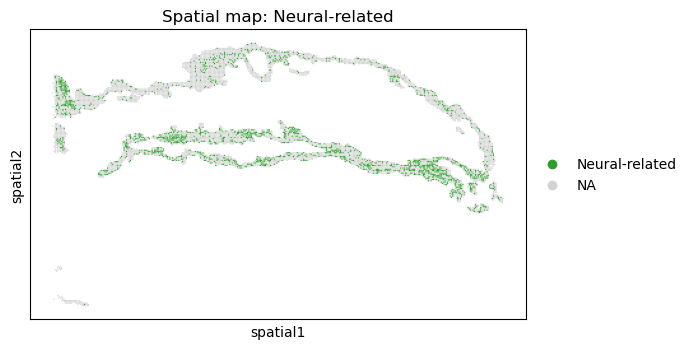

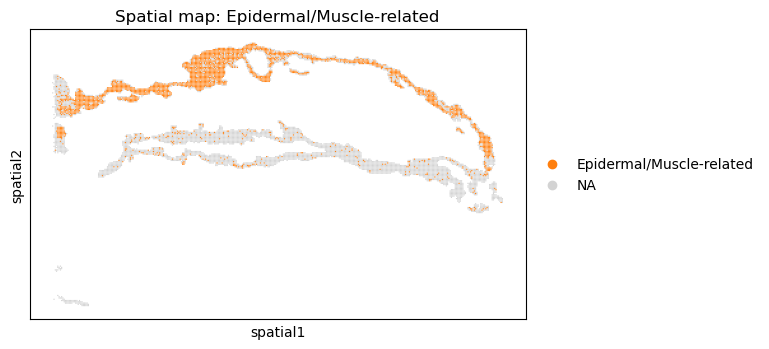

In [77]:
celltypes = st_AureliaMargin_og.obs["cluster_annos"].unique().tolist()

for ct in celltypes:
    sc.pl.spatial(
        st_AureliaMargin_og,
        color="cluster_annos",
        groups=[ct],          # ⭐ 只显示一个 celltype
        spot_size=50,
        title=f"Spatial map: {ct}"
    )


In [62]:
# 皮层肌肉相关 OG0001527
# gene-evm.model.ptg000021l.289#TPM2-PODCA#Q9U5M4,OG0002736
# XLOC-003006#APLP-LOCMI#Q9U943,OG0001527
# XLOC-003850#APLP-LOCMI#Q9U943,OG0001527
# XLOC-025489#APOB-RAT#Q7TMA5,OG0001527
# gene-evm.model.ptg000007l.745#APOB-RAT#Q7TMA5,OG0001527
# gene-evm.model.ptg000011l.231#APLP-LOCMI#Q9U943,OG0001527

# 神经细胞相关 OG0000393
# XLOC-002149#XLOC-002149,OG0000393
# XLOC-009553#SNX27-MOUSE#Q3UHD6,OG0000393
# XLOC-013940#HCN2-HUMAN#Q9UL51,OG0000393
# XLOC-022104#CNGA2-BOVIN#Q03041,OG0000393
# XLOC-024044#CNGA3-MOUSE#Q9JJZ8,OG0000393
# XLOC-025648#HCN4-HUMAN#Q9Y3Q4,OG0000393
# gene-evm.model.ptg000021l.24#ACDSB-RAT#P70584,OG0000393

# 刺细胞相关 OG0011646
# XLOC-021328#XLOC-021328,OG0011646
# gene-evm.model.ptg000018l.390#gene-evm.model.ptg000018l.390,OG0011646

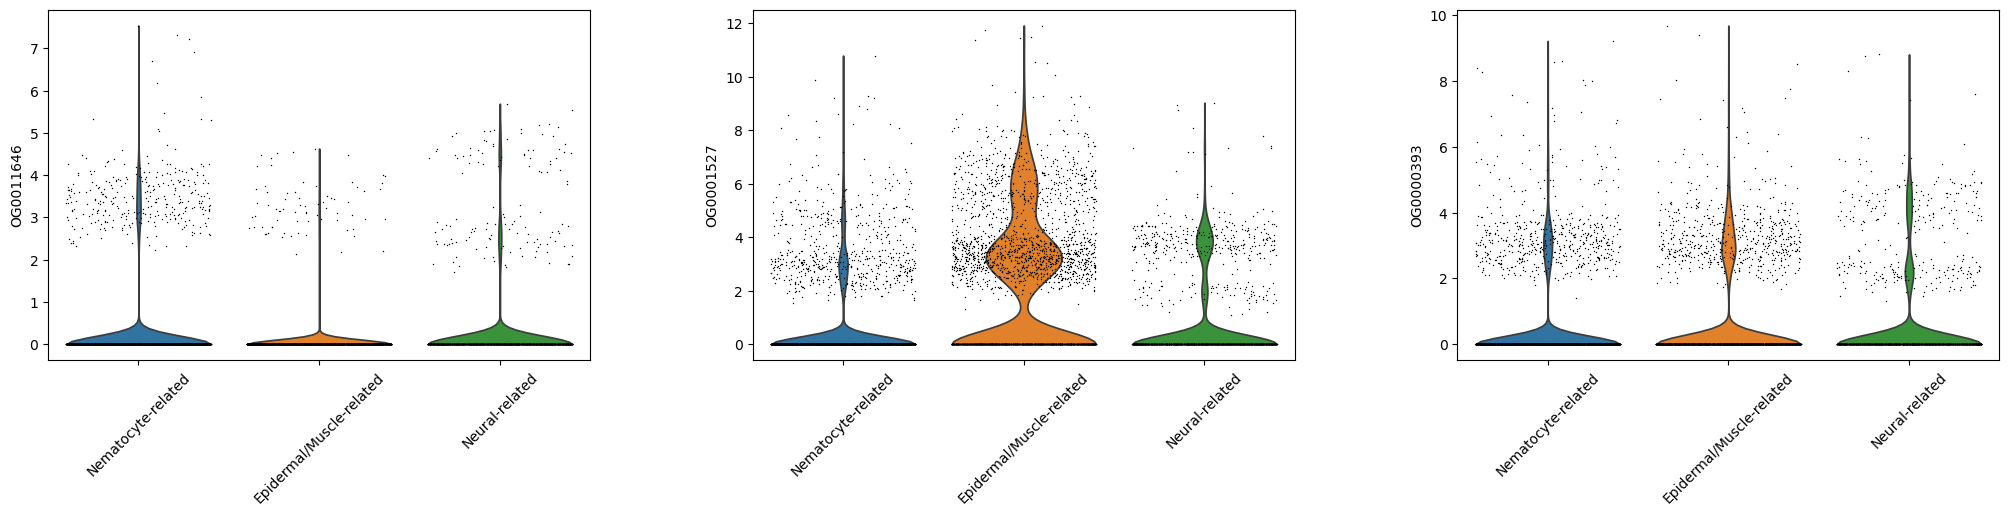

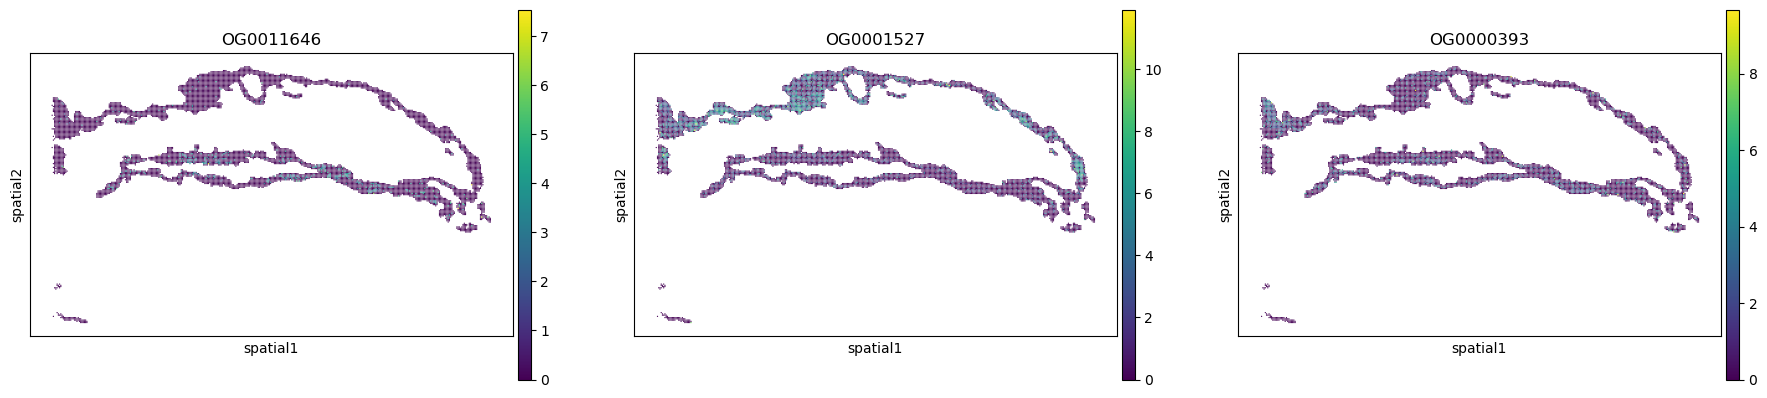

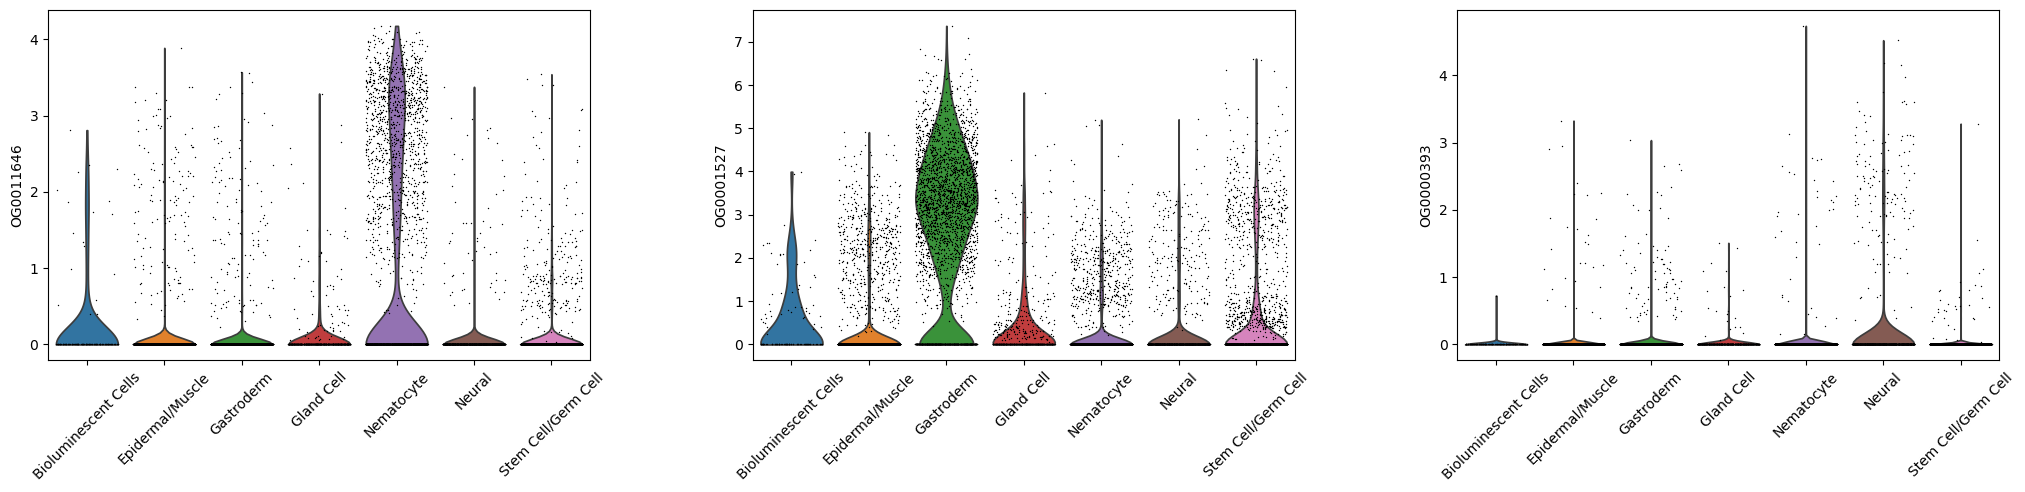

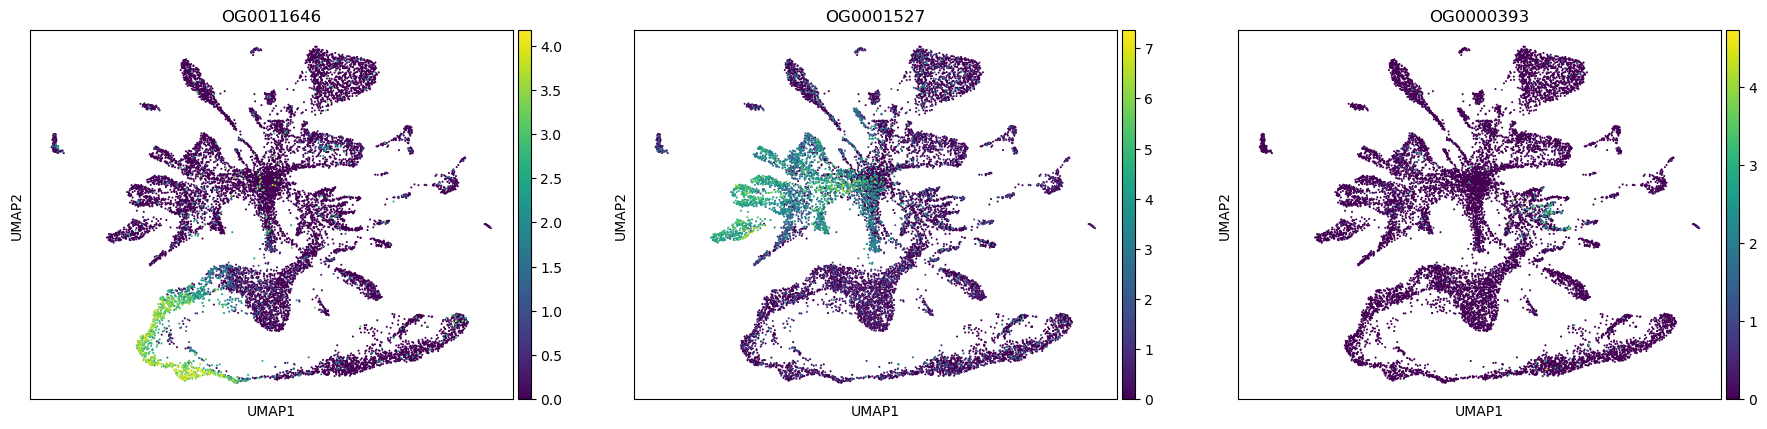

In [71]:
final_markers = ['OG0011646', 'OG0001527', 'OG0000393']
sc.pl.violin(st_AureliaMargin_og, keys=final_markers, groupby="cluster_annos", jitter=0.4, rotation=45, stripplot=True)
sc.pl.spatial(st_AureliaMargin_og, color=final_markers, spot_size=50)
sc.pl.violin(sc_Clytia_og, keys=final_markers, groupby="annos", jitter=0.4, rotation=45, stripplot=True)
sc.pl.umap(sc_Clytia_og, color=final_markers)

In [68]:
# Obtain cluster-specific differentially expressed genes
st_AureliaMargin_og.obs["cluster_annos"] = st_AureliaMargin_og.obs["cluster_annos"].astype("category")
# 备份原 Leiden 的 DE
st_AureliaMargin_og.uns["rank_genes_groups_leiden"] = st_AureliaMargin_og.uns["rank_genes_groups"].copy()
sc.tl.rank_genes_groups(st_AureliaMargin_og, groupby="cluster_annos", method="wilcoxon")

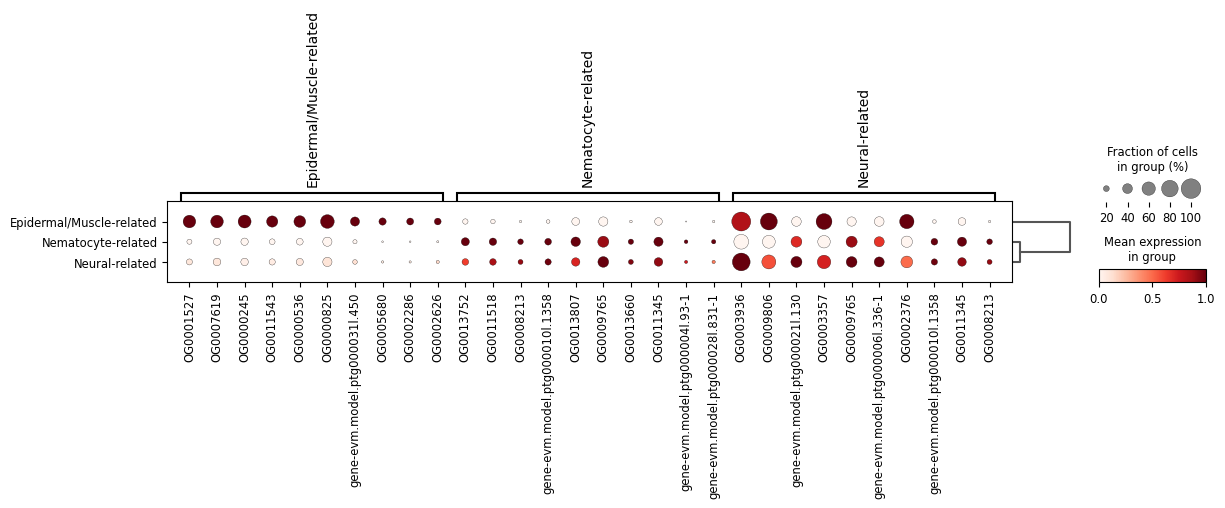

In [69]:
# 绘制每组前 15 个 marker 基因的 dotplot
sc.pl.rank_genes_groups_dotplot(
    st_AureliaMargin_og,
    groupby='cluster_annos',
    n_genes=10,
    standard_scale='var',
    show=True,
    # swap_axes=True,
    # color_map='RdBu_r',
    # figsize=(12, 8)
)

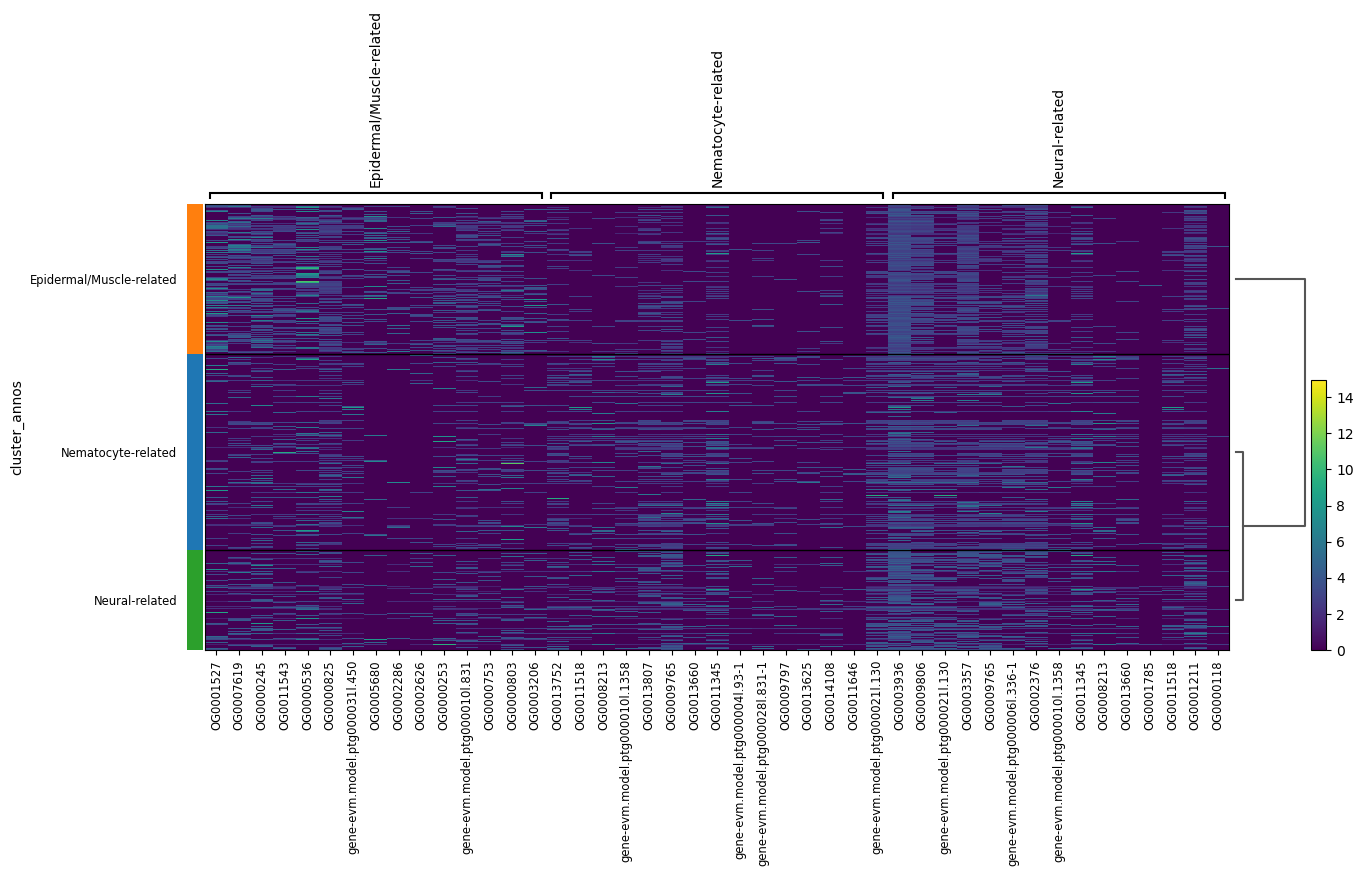

In [70]:
sc.pl.rank_genes_groups_heatmap(
    st_AureliaMargin_og, groupby="cluster_annos", n_genes=15
)